In [1]:
from sage.all import *
import building_vertex
from utils import *

#### $ E=\mathbb{Q}[x]/(x^2+2) $
$ E_2=\mathbb{Q}_2[x]/(x^2+2) $

$T = \sqrt{-2} \in E$ 

$t = \sqrt{-2} \in E_2$

In [2]:
p = 2
poly = x^2+2
Q_p = Qp(p,print_mode='bars',prec=50)
Ep.<t> = Q_p.extension(poly)
E.<T> = QQ.extension(poly)

uniformizer = t

p_val = lambda a: Ep(a).valuation()
p_norm = lambda a: uniformizer ** -p_val(a)

def approximate_E(a):
    digit_to_remove = uniformizer^(Ep.precision_cap()-5)
    return E(Ep(a) % digit_to_remove% digit_to_remove)
    

def get_rep(M):
    rep =  building_vertex.get_rep(M,Ep,E,p_val,p_norm)
    return building_vertex.convert_matrix(rep,approximate_E)

In [3]:
# J = Matrix([[0,0,1],[0,1,0],[1,0,0]])

involution = lambda M:get_rep((get_rep(M).C.T)^-1)

def length(g):
    d = g.nrows()
    p_vals = [p_val(g[i,j]) for i in range(d) for j in range(d)]
    return p_val(det(g)) - d*min(p_vals)
                          
dist = lambda g: (length(g)+length(g^-1))//g.nrows()

In [4]:
import itertools
from multiprocessing import Pool, cpu_count

def E_iter(n=p, with_negatives = False):
    if n==T:
        n=p # replace T by p
    nrange = range(-n,n) if with_negatives else range(n)
    for a, b in itertools.product(nrange,repeat=2):
        yield a + b * T


def check_triplet(args):
    a, b, c, x, y, z = args
    M = Matrix(3, [a, x, y,
                   0, b, z,
                   0, 0, c])
    rep = get_rep(M)
    rep.set_immutable()
    if dist(rep) == 1:
        return rep
    return None

def create_neighbors_parallel():
    neighbors = set() 
    args_list = []
    
    for a, b, c in itertools.product([1, T], repeat=3):
        E_a = list(E_iter(a))
        E_b = list(E_iter(b))
        for x in E_a:
            for y in E_a:
                for z in E_b:
                    args_list.append((a, b, c, x, y, z))
    
    with Pool(cpu_count()) as pool:
        results = pool.map(check_triplet, args_list)
    for r in results:
        if r is not None:
            neighbors.add(r)
    
    return neighbors

neighbors = create_neighbors_parallel()
len(neighbors)

14

In [5]:
def are_neighbors(A,B):
    """
    if exists N in neighbors s.t. AK=BNK or ANK=BK
    equivalently B^-1A in NK or A^-1B in NK <=> dist(B^-1A)=1 or dist(A^-1B)=1
    """
    return dist(B^-1*A)==1 or dist(A^-1*B)==1
    # for n in neighbors:
    #     if get_rep(A) == get_rep(B*n) or  get_rep(B) == get_rep(A*n):
    #         return True
    # return False


def flipped_edge(A):
    """
    check if (A, involution(A)) is an edge in the building (and therefore flipped by the action of #)
    """
    return are_neighbors(A,involution(A))


def is_fixed_point(A):
    return get_rep(A) == get_rep(involution(A))

        
def set_im(M):
    M.set_immutable()
    return M

def im_rep(M):
    return set_im(get_rep(M))
    
Id = set_im(diag(1,1,1))
fedges = [n for n in neighbors if flipped_edge(n) and length(n)==1]

In [6]:
def get_flipped_edge(k,n):
    kn = k*n
    rep, inv= im_rep(k*n),im_rep(involution(k*n))
    if flipped_edge(kn) and length(kn)<=length(inv):
        return rep,inv
    return None

def get_fixed_point(pair,n):
    point = im_rep(pair[0]*n) 
    if is_fixed_point(point):
        return point
    return None

def build_tree(depth=0):
    """
    build neighbors list for the tree, up to given depth 
    """
    level_fixed_points = [Id]
    level_flipped_egdes = []#[(k,set_im(involution(k))) for k in fedges]
    vertices_list = {}
    # vertices_list = {Id:levelflipped_egdes.copy()}
    
    for i in range(depth):
        if i%2==0:
            #add flipped edges:
            new_values = {k:list(filter(None,[get_flipped_edge(k,n) for n in neighbors])) 
                          for k in level_fixed_points}
            level_flipped_egdes = [pair  for pair_list in new_values.values() for pair in pair_list]

        else:
            #add fix points
            new_values ={pair:list(filter(None,[get_fixed_point(pair,n) for n in neighbors])) for pair in level_flipped_egdes}
            level_fixed_points = [fpoint for flist in new_values.values() for fpoint in flist]
        vertices_list.update(new_values)
            
    return vertices_list

In [7]:
from math import cos, sin, pi

def radial_tree_positions(G, root, step=1.3):
    """
    Return {vertex: (x,y)} with root at (0,0) and each root-branch in its own sector.
    step = radial distance per depth.
    """
    # Build rooted children dict (BFS)
    parent = {root: None}
    order  = [root]
    children = {}
    for u in order:
        kids = []
        for v in G.neighbors(u):
            if v not in parent:
                parent[v] = u
                kids.append(v)
                order.append(v)
        children[u] = kids

    # Handle degenerate tree
    if not children[root]:
        return {root: (0.0, 0.0)}

    # Subtree sizes (to space nodes proportionally inside each sector)
    size = {u: 1 for u in order}
    for u in reversed(order):
        for v in children[u]:
            size[u] += size[v]

    pos = {root: (0.0, 0.0)}

    def lay(u, a0, a1, depth):
        if a1 <= a0:
            return
        am = 0.5 * (a0 + a1)
        r  = depth * step
        pos[u] = (r * cos(am), r * sin(am))
        tot = sum(size[v] for v in children[u])
        a = a0
        for v in children[u]:
            span = (a1 - a0) * (size[v] / tot) if tot else 0
            lay(v, a, a + span, depth + 1)
            a += span

    # Split full circle equally among root's children (different directions)
    k = len(children[root])
    for i, v in enumerate(children[root]):
        a0 = 2 * pi * i / k
        a1 = 2 * pi * (i + 1) / k
        lay(v, a0, a1, 1)

    return pos


def two_mat_to_str(A,B):
    ret_val = ''
    for rowA , rowB in zip(A,B):
        ret_val+= str(list(rowA)) + '    '  + str(list(rowB)) + '\n'
    return ret_val

def label_func(v):
    if type(v) == tuple:
        return two_mat_to_str(v[0],v[1])
    return str(v)   

def color_by_dist(v):
    if type(v) == tuple:
        return dist(v[0])
    return dist(v)

from math import hypot
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex

def numeric_to_color_classes(vals, cmap_name='viridis'):
    lo, hi = min(vals.values()), max(vals.values())
    if hi == lo: hi = lo + 1.0
    cmap = get_cmap(cmap_name)
    color_classes = {}
    for v, x in vals.items():
        t = (x - lo) / (hi - lo)
        color_classes.setdefault(to_hex(cmap(t)), []).append(v)
    return color_classes

In [9]:
tree = build_tree(4)
graph = Graph(tree)

/tmp/ipykernel_861/1875395982.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name)


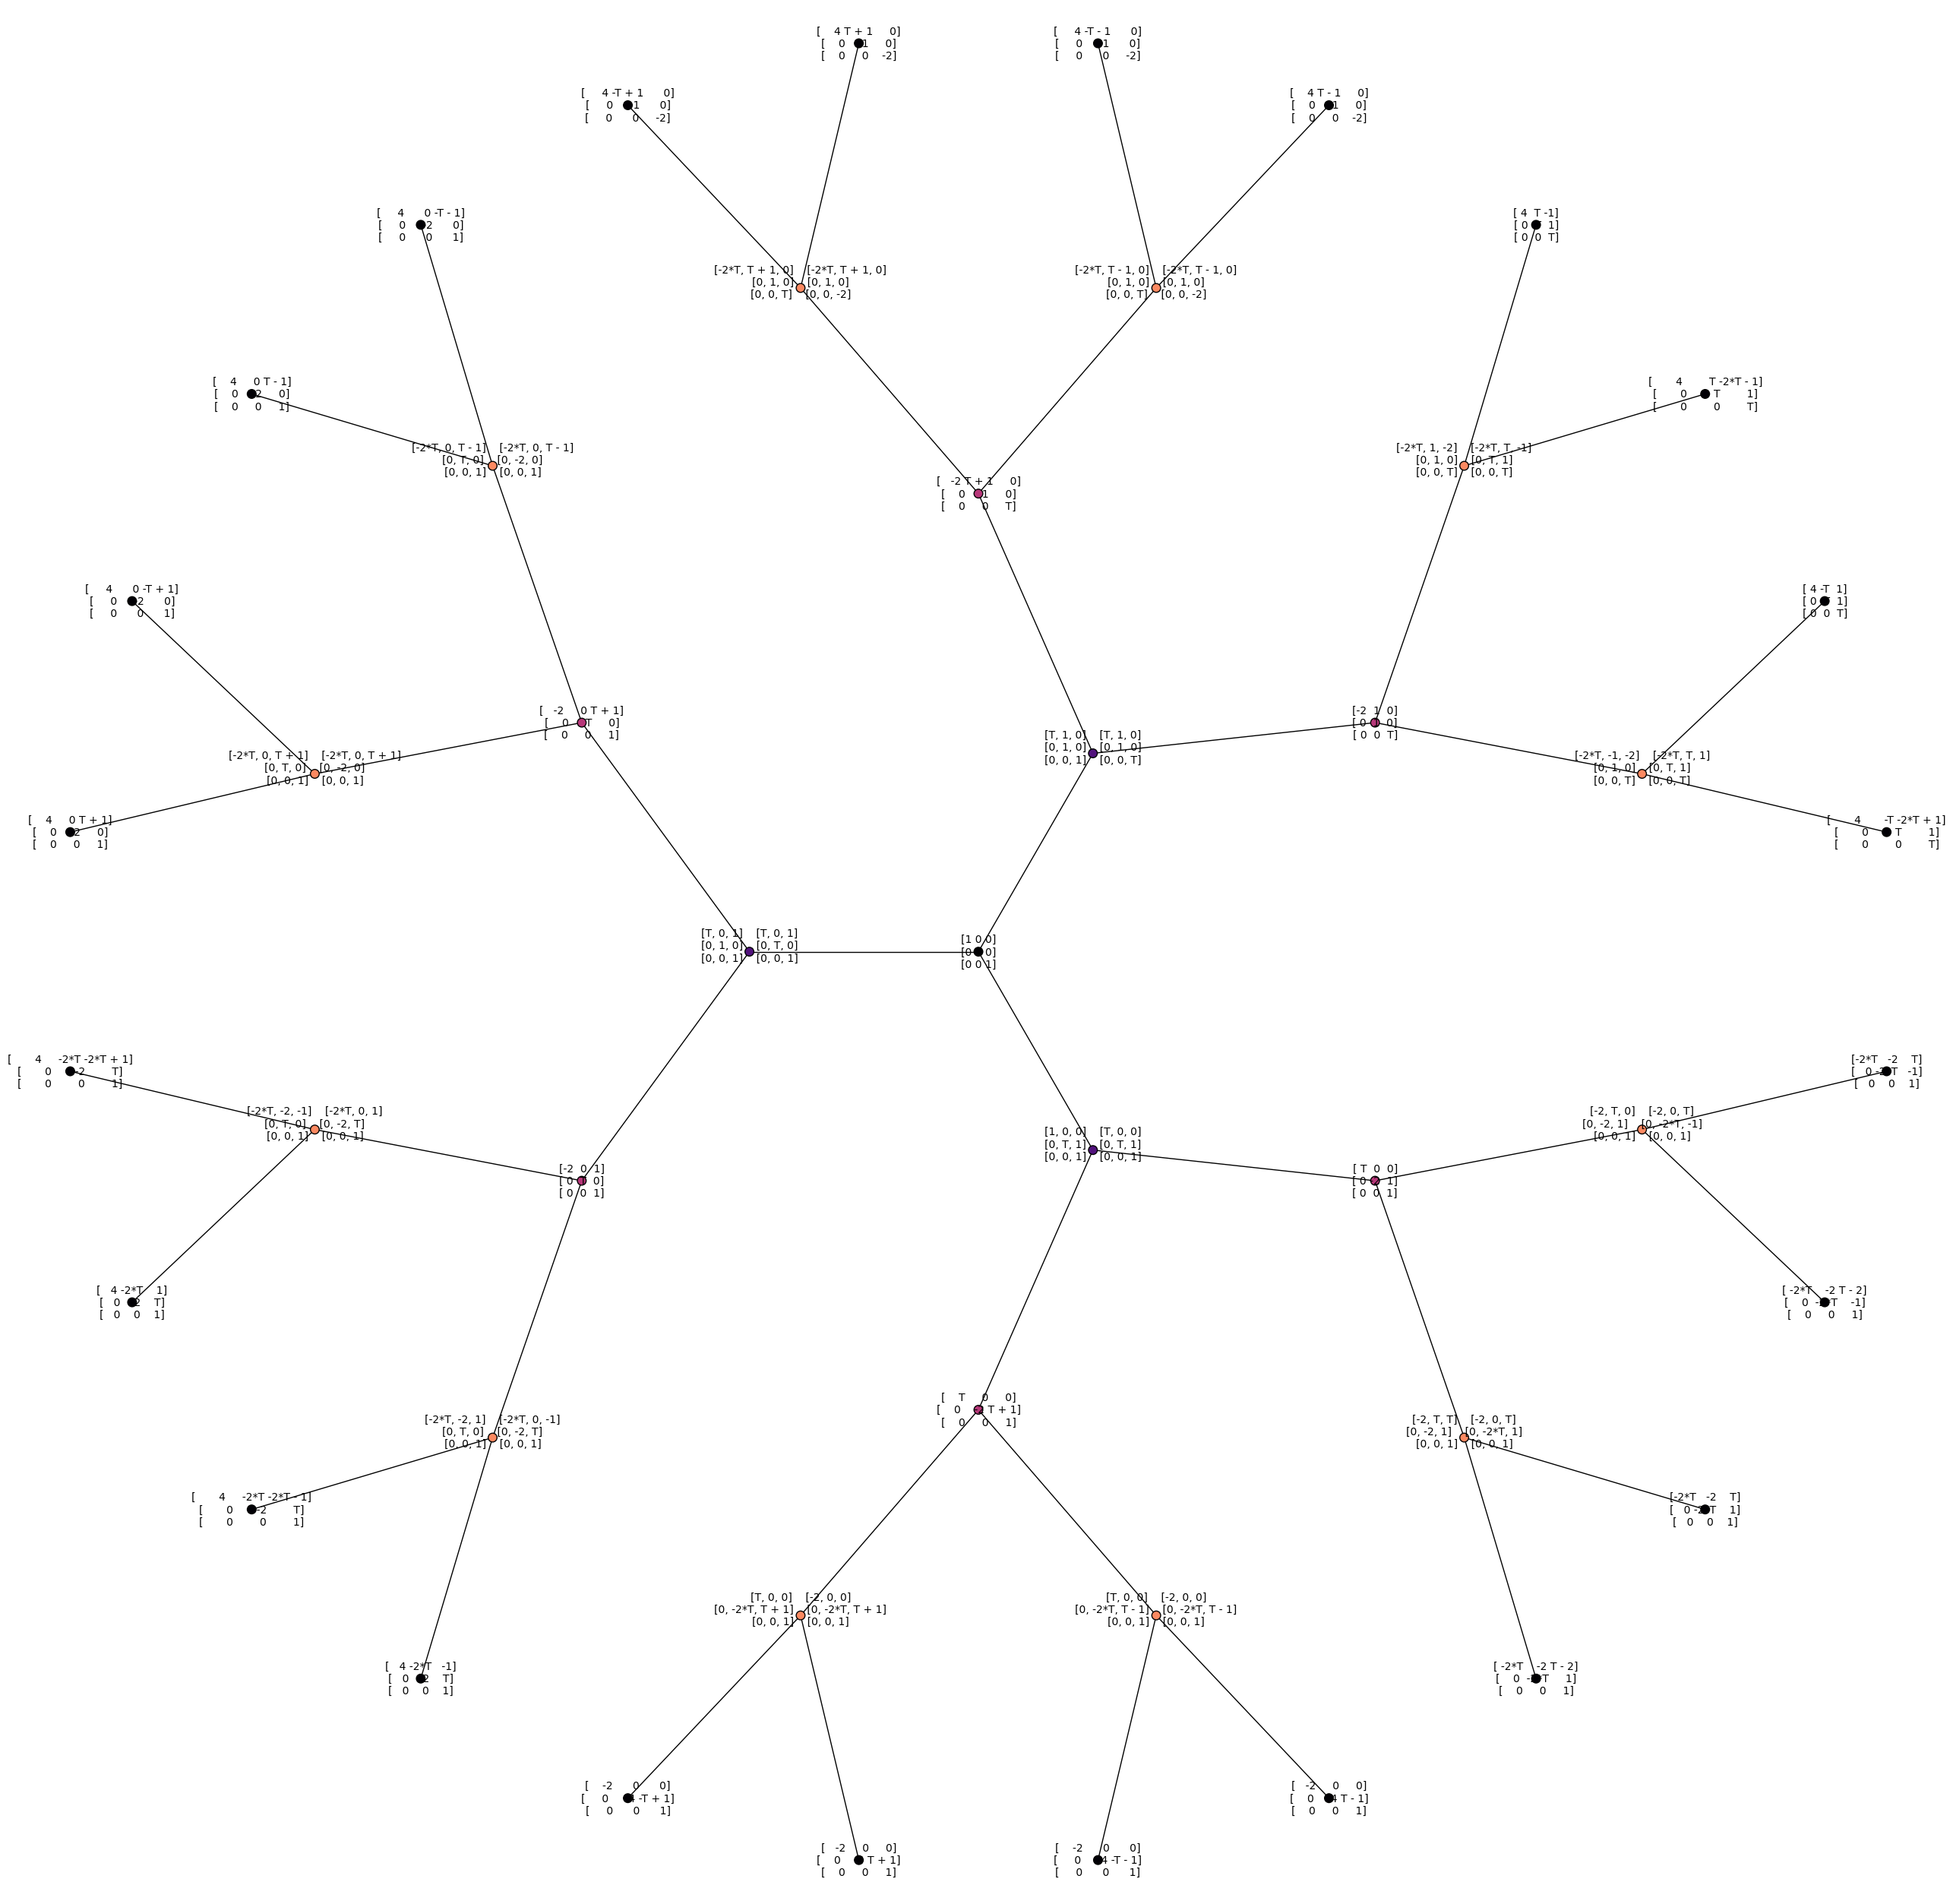

In [10]:
labels = {v: label_func(v) for v in graph.vertices()}
vcolors = numeric_to_color_classes({v: color_by_dist(v) for v in graph.vertices()}, cmap_name='magma')
pos = radial_tree_positions(graph, root=Id, step=1.6)

graph.show(pos=pos, vertex_labels=labels, vertex_size=70,vertex_colors = vcolors,figsize=(26,50))


# Action of $GU_3(\mathbb{Z}[\sqrt{-2},\frac{1}{2}])$ on the tree
## $GU_3(\mathbb{Z}[\sqrt{-2},\frac{1}{2}]) = \left\{ A\in M_{3}\left(\mathbb{Z}\left[\sqrt{-2},\frac{1}{2}\right]\right)\mid AA^{*}=2^{i}I\right\} $

In [11]:
unitary_act = lambda A:A*A.T.C
unitary_cond = lambda A,n:unitary_act(A) == diag(n,n,n)

In [11]:
def create_norms_dict(n=1,with_negatives=True):
    norms_dict = {}
    for x in E_iter(n+1,with_negatives=with_negatives):
        n = norm(x)
        if n not in norms_dict.keys():
            norms_dict[n]=[]
        norms_dict[n].append(x)
    return norms_dict

def get_norm_vector(n,norms_dict=None):
    """
    return all the vectors of 
    """
    if norms_dict is None:
        norms_dict=create_norms_dict(n)
    
    keys = [a for a in norms_dict.keys() if a <=n]
    vectors = []
    for a,b in itertools.product(keys,repeat=2):
        c = n-a-b
        if c>=0 and c in keys:
            for x,y,z in itertools.product(norms_dict[a],norms_dict[b],norms_dict[c]):
                vectors.append((x,y,z))
    return vectors

def perp(v1,v2):
    return sum(v1[i]*v2[i].conjugate() for i in range(len(v1))) == 0

def create_perp_graph(n_vectors):
    """
    build a graph which its vertices are vectors of norm n, and edges connect each pair of vectors which perpendicular to each other.
    """
    return {v:{u for u in n_vectors if perp(u,v)} for v in n_vectors}

def div_min_val(M):
    minval = min(p_val(M[i,j]) for i in range(M.nrows()) for j in range(M.ncols()))
    return set_im(M/(T^minval))

def find_GU(n=1):
    n_vectors = get_norm_vector(n)
    n_graph = create_perp_graph(n_vectors)
    unitaries = set()
    prep_couples = [(v1,v2) for v1 in n_vectors for v2 in n_graph[v1]]
    for v1,v2 in prep_couples:
        common_perps = n_graph[v1]&n_graph[v2]
        for v3 in common_perps:
            U = set_im(div_min_val(Matrix([v1,v2,v3])))
            unitaries.add(U)
    return unitaries

In [17]:
NN=16
unitaries = find_GU(NN)

In [18]:
sorted_unitary = {i:set() for i in  divisors(NN)}
for n in unitaries:
    for i in  divisors(NN):
        if unitary_cond(n,i):
            sorted_unitary[i].add(n)
[(i,len(us)) for i,us in sorted_unitary.items()]

[(1, 48), (2, 144), (4, 864), (8, 2880), (16, 12672)]

In [15]:
from multiprocessing import Pool, cpu_count
graph_vertices = set(graph.vertices())


# --- globals visible in worker processes ---
V = None          # the matrix 'v' to multiply on the right
PAIR = False      # whether to return (im_rep(uv), im_rep(involution(uv)))
GV = None         # optional: graph_vertices to filter in-worker

def _init_worker(v, pair, graph_vertices=None):
    global V, PAIR, GV
    V, PAIR, GV = v, pair, graph_vertices

def _apply(u):
    uv = u * V
    out = (im_rep(uv), im_rep(involution(uv))) if PAIR else im_rep(uv)
    if GV is None:
        return out
    return out if out in GV else None

def get_orbit(v, unitaries, pair=False, graph_vertices=graph_vertices,
              processes=None, chunksize=256):
    with Pool(processes or cpu_count(),
              initializer=_init_worker,
              initargs=(v, pair, graph_vertices)) as pool:
        results = pool.map(_apply, unitaries, chunksize=chunksize)
    # filter out Nones if we did membership in-worker
    return {r for r in results if r is not None} if graph_vertices is not None else results


In [8]:
v1 = Matrix(3,[T,1,0,
              0,1,0,
              0,0,1])
v2= Matrix(3,[-2,T+1,0,
              0,1,0,
              0,0,T])

In [17]:
cay = lambda A: (Id-A)*(Id+A)^-1

In [19]:
bounded_unitaries = sorted_unitary[1]|sorted_unitary[2] |sorted_unitary[4] #|sorted_unitary[8]|sorted_unitary[16]

In [ ]:
v0_orbit = get_orbit(Id,bounded_unitaries)
v1_orbit = get_orbit(v1,bounded_unitaries,pair=True)
v2_orbit = get_orbit(v2,bounded_unitaries)

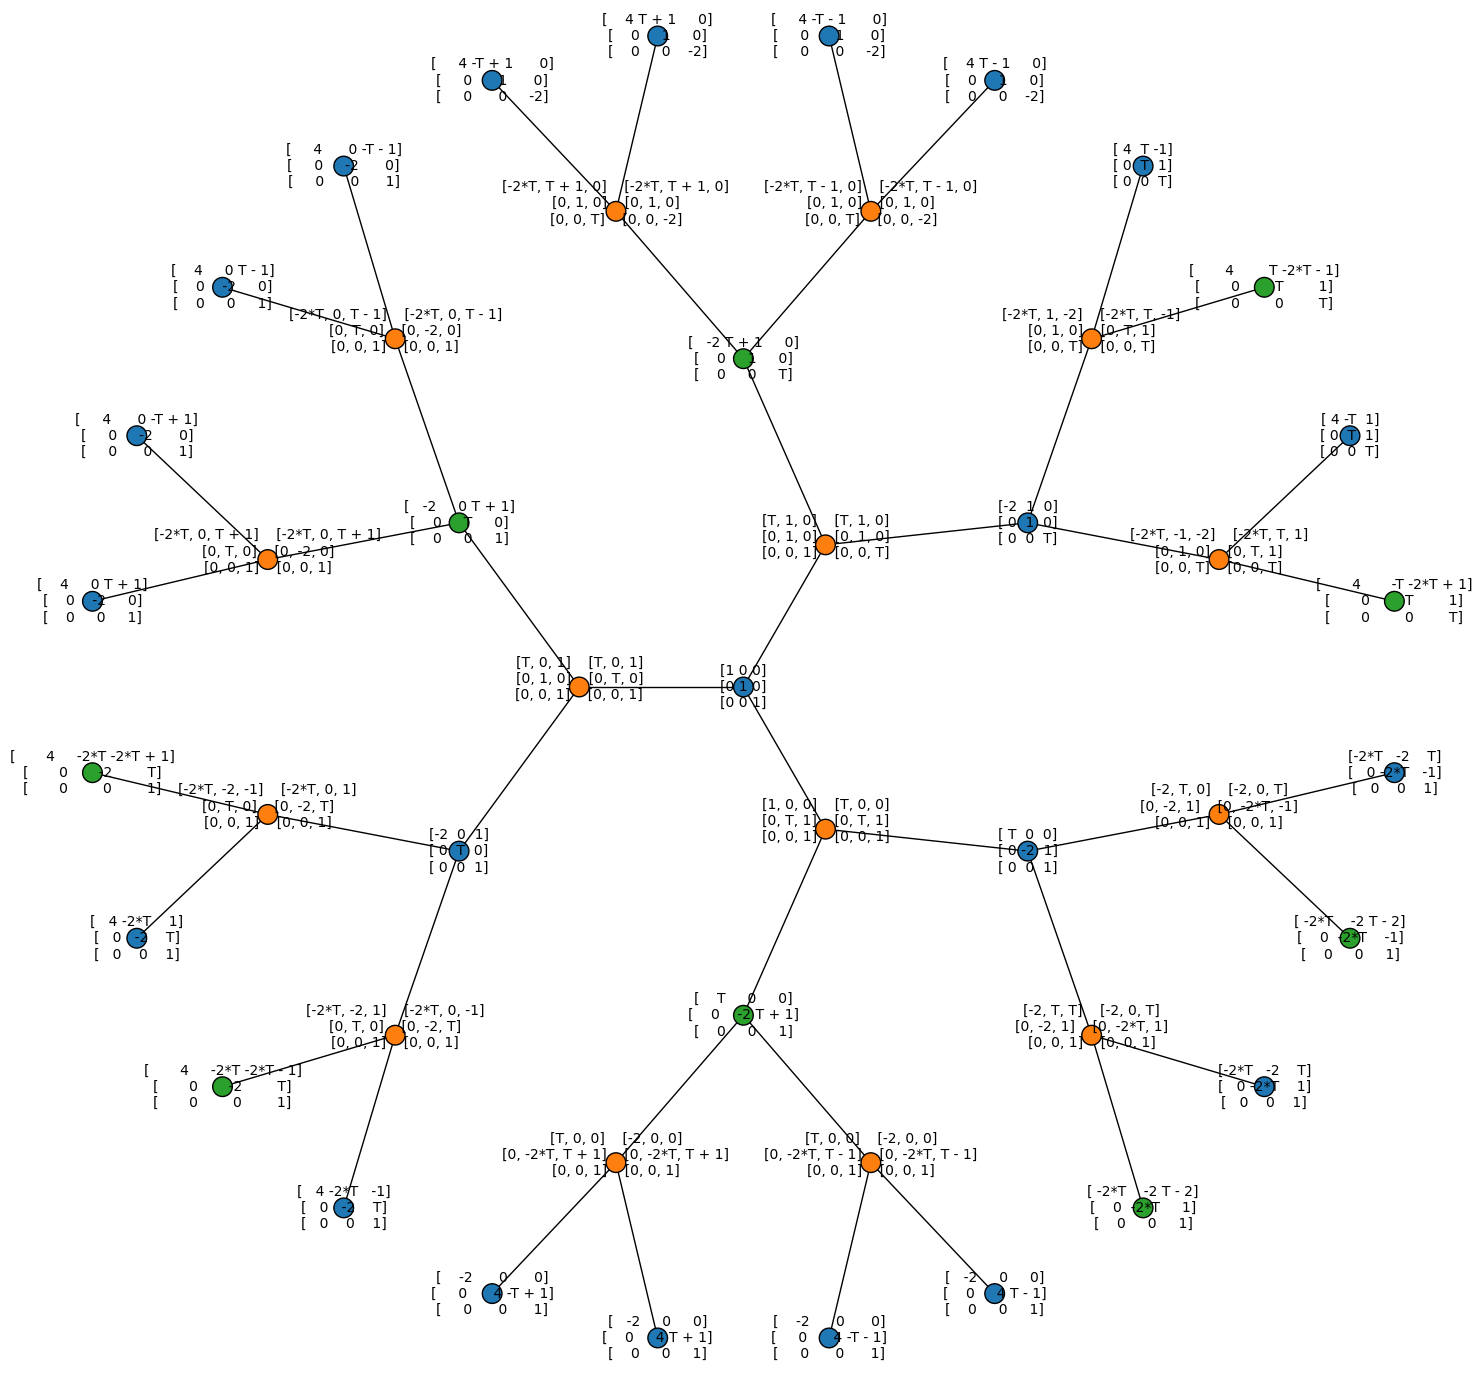

In [20]:
rest = set(graph.vertices()) - (v0_orbit | v1_orbit | v2_orbit)

# Pick your colors and plot
vc = {
    'tab:blue':   list(v0_orbit),
    'tab:orange': list(v1_orbit),
    'tab:green':  list(v2_orbit),
    'lightgray':  list(rest)   
}


labels = {v: label_func(v) for v in graph.vertices()}
pos = radial_tree_positions(graph, root=Id, step=1.6)

graph.show(pos=pos, vertex_labels=labels, vertex_size=200,vertex_colors = vc,figsize=(15,50))

## factor graph

In [21]:
V0 = set_im(Id)
V1 = (set_im(v1), set_im(involution(v1)))
V2 = set_im(v2)

factor_graph_adjancy = {V0:[V1],V1:[V2]}
factor_graph = Graph(factor_graph_adjancy)

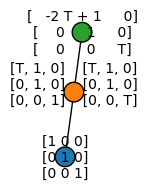

In [22]:
vc = {
    'tab:blue':   [V0],
    'tab:orange': [V1],
    'tab:green':  [V2],
    # 'lightgray':  list(rest)   
}


labels = {v: label_func(v) for v in factor_graph.vertices()}

factor_graph.show( vertex_labels=labels, vertex_size=200,vertex_colors = vc,figsize=(4,2))

so we get  $ GU_{3}\left(\mathbb{Z}\left[\sqrt{-2},\frac{1}{2}\right]\right)\cong stab\left(v_{0}\right)*_{stab\left(v_{0}\right)\cap stab\left(v_{1}\right)}stab\left(v_{1}\right)*_{stab\left(v_{1}\right)\cap stab\left(v_{2}\right)}stab\left(v_{2}\right) $

## stabilizers

In [22]:
print_mat(v2)

[[ -2, T + 1, 0],
[ 0, 1, 0],
[ 0, 0, T]]


In [93]:
for U in sorted_unitary[2]:
    for V in unitaries_25:
        VU = V*U
        if get_rep(VU)== v2:
            print_mat(VU)

[[ 2, -3*T - 1, T + 5],
[ -2*T + 4, -3, 2*T - 3],
[ -3*T - 2, -3*T + 2, -T - 2]]
[[ 6, -T + 1, T - 3],
[ 2*T, 2*T - 1, 4*T + 1],
[ T + 2, -T - 6, -T + 2]]
[[ -2*T + 2, T - 3, -T + 5],
[ 4*T, 1, -2*T + 3],
[ -T + 2, T + 6, T + 2]]
[[ 4, 1, 4*T + 1],
[ 2*T - 2, 3*T - 3, T + 3],
[ -3*T - 2, 3*T + 2, T - 2]]
[[ 4*T, -1, 2*T - 3],
[ -2*T + 2, -T + 3, T - 5],
[ -T + 2, -T - 6, -T - 2]]
[[ 2*T, 2*T - 1, 2*T - 5],
[ -4*T + 2, -T - 1, T - 3],
[ -T - 2, T + 6, -T - 2]]
[[ 4*T, 3, -2*T - 1],
[ -2*T - 2, -3*T + 1, -3*T - 1],
[ T - 2, -3*T + 2, 3*T + 2]]
[[ -2, -3*T - 3, -3*T + 1],
[ 2*T - 4, 2*T + 3, -2*T + 1],
[ -3*T + 2, T + 2, -3*T - 2]]
[[ 2*T, 4*T - 3, -1],
[ 2, -T - 1, 3*T - 5],
[ T + 6, -T - 2, -T + 2]]
[[ 2, -3*T - 5, T - 1],
[ 2*T, 1, 4*T + 3],
[ T - 6, -T - 2, -T + 2]]
[[ -2, -3*T - 1, T + 5],
[ -2*T + 4, 3, -2*T + 3],
[ 3*T + 2, -3*T + 2, -T - 2]]
[[ 2*T, -4*T - 1, 2*T - 1],
[ -6, T - 3, T - 1],
[ T + 2, T - 2, -T - 6]]
[[ 0, 5, 5],
[ -2*T - 6, -T - 1, T + 1],
[ -T - 2, 3*T + 2, -3*T - 

KeyboardInterrupt: 

In [56]:
filename = 'unitary_2.pkl'

with open(filename,'wb') as f:
    # pickle.dump(sorted_unitary[1]|sorted_unitary[2], f)
    pickle.dump(sorted_unitary[1]|sorted_unitary[2]|sorted_unitary[4], f)

In [24]:
M = Matrix([[ 2, -3*T - 1, T + 5],
    [ -2*T + 4, -3, 2*T - 3],
    [ -3*T - 2, -3*T + 2, -T - 2]]
    )/(5*T)

im_rep(M)

[   -2 T + 1     0]
[    0     1     0]
[    0     0     T]

In [61]:
v2

[   -2 T + 1     0]
[    0     1     0]
[    0     0     T]

In [59]:
M

[      -1/5*T 1/10*T - 3/5 -1/2*T + 1/5]
[-2/5*T - 2/5       3/10*T 3/10*T + 2/5]
[ 1/5*T - 3/5 -1/5*T - 3/5  1/5*T - 1/5]

In [23]:
V0_stabilizer = sorted_unitary[1]

V1_stabilizer = {u for u in sorted_unitary[1]|sorted_unitary[2] if im_rep(u*V1[0])==V1[0]}
V2_stabilizer = {u for u in sorted_unitary[1]|sorted_unitary[2]|sorted_unitary[4] if im_rep(u*V2)==V2}

e0_stab = V0_stabilizer&V1_stabilizer

In [26]:
len(V2_stabilizer)

96

In [27]:
import pickle
file_name = "b_stab_U3(Zsqrtm2_2)_tree.pkl"

with open(file_name, "wb") as f:
    M_stab = pickle.load(f)

In [38]:
{div_min_val(a) for a in M_stab} == V2_stabilizer

True

In [55]:
M = Matrix([[ -1/10*T, 3/5*T - 1/5, 3/10*T + 1/5],
            [ -4/5, -1/5*T - 1/5, 1/5*T + 2/5],
            [ -3/10*T - 2/5, 1/5*T - 1/5, -1/2*T - 1/5]] )
im_rep(M) in v2_orbit

False

In [51]:
v0_orbit

{[    -2      0      0]
 [     0      4 -T - 1]
 [     0      0      1],
 [   -2     0     0]
 [    0     4 T - 1]
 [    0     0     1],
 [    -2      0      0]
 [     0      4 -T + 1]
 [     0      0      1],
 [   -2     0     0]
 [    0     4 T + 1]
 [    0     0     1],
 [-2  0  1]
 [ 0  T  0]
 [ 0  0  1],
 [-2  1  0]
 [ 0  1  0]
 [ 0  0  T],
 [-2*T   -2    T]
 [   0 -2*T   -1]
 [   0    0    1],
 [-2*T   -2    T]
 [   0 -2*T    1]
 [   0    0    1],
 [ T  0  0]
 [ 0 -2  1]
 [ 0  0  1],
 [1 0 0]
 [0 1 0]
 [0 0 1],
 [     4 -T - 1      0]
 [     0      1      0]
 [     0      0     -2],
 [    4 T - 1     0]
 [    0     1     0]
 [    0     0    -2],
 [   4 -2*T   -1]
 [   0   -2    T]
 [   0    0    1],
 [   4 -2*T    1]
 [   0   -2    T]
 [   0    0    1],
 [ 4 -T  1]
 [ 0  T  1]
 [ 0  0  T],
 [     4      0 -T - 1]
 [     0     -2      0]
 [     0      0      1],
 [    4     0 T - 1]
 [    0    -2     0]
 [    0     0     1],
 [     4      0 -T + 1]
 [     0     -2      0]
 [     0

In [44]:
get_rep(V0)

[1 0 0]
[0 1 0]
[0 0 1]

In [32]:
ZG = {a for a in V2_stabilizer if all(div_min_val(a*b)==div_min_val(b*a) for b in V2_stabilizer)}

In [35]:
G_comm = {div_min_val(a*b*a^-1*b^-1) for a in V2_stabilizer for b in V2_stabilizer}
G_comm2 = {div_min_val(a*b*a^-1*b^-1) for a in G_comm for b in G_comm}
G_comm3 = {div_min_val(a*b*a^-1*b^-1) for a in G_comm2 for b in G_comm2}
G_comm4 = {div_min_val(a*b*a^-1*b^-1) for a in G_comm3 for b in G_comm3}

In [31]:
import pandas as pd
pd.Series([matrix_order(a,projected=True) for a in V2_stabilizer]).value_counts()

2    27
8    24
6    24
4    12
3     8
1     1
Name: count, dtype: int64

In [104]:
HA1=T/2*A1
HA2=1/2*A2

HA1_orbit = [set_im(HA1^j) for j in range(4)]
HA2_orbit = [set_im(HA2^j) for j in range(6)]


In [126]:
len({set_im(c*b*a) for a in e0_stab for b in HA1_orbit for c in HA2_orbit})

96

In [187]:
log(8,2)

3

In [192]:
unitary_act(A1)

[4 0 0]
[0 4 0]
[0 0 4]

In [197]:
log(int(unitary_act(A)[0,0]),2)

2

In [211]:
get_k = lambda A: log(int(unitary_act(A)[0,0]),2)
normalized_unitary_act = lambda A: unitary_act(A/(T^get_k(A)))


normalized_unitary_act(A1)

TypeError: no common canonical parent for objects with parents: 'Number Field in T with defining polynomial x^2 + 2' and 'The Infinity Ring'

In [185]:
unitary_act(1/T*A1)

[1 0 0]
[0 1 0]
[0 0 1]

In [164]:
(1/T^51).conjugate()*(1/T^51) == 1/2^51

True

In [155]:
unitary_act(A1/(T^(dist(A1)/2)))


[1 0 0]
[0 1 0]
[0 0 1]

In [127]:
len(V0_stabilizer),len(V1_stabilizer),len(V2_stabilizer)

(48, 32, 96)

In [125]:
len(V0_stabilizer&V1_stabilizer),len(V1_stabilizer&V2_stabilizer)

(16, 32)

$stab\left(v_{0}\right)$ is all the permutations matrices, but with $\pm 1$ in each coordinate, so 
$$ stab\left(v_{0}\right)\cong S_{3}\ltimes\left(\mathbb{Z}/ 2\mathbb{Z}\right)^{3} $$


In [25]:
def is_subgroup(H):
    return all(set_im(g*h) in H for g,h in itertools.product(H,repeat=2))

def is_normal_subgroup(H,G):
    """
    H <= G
    """
    return all(set_im(g*h*g^-1) in H for g in G for h in H)
    
def is_semidirect_product(G,N,H,e=Id):
    """
    for a matrices group G (given as a set of elements)
    check if :
    1. H,N <= G
    2. N is normal in G
    3. H intersect N is {e}
    4. NH = G
    """
    cond1 = is_subgroup(N) and is_subgroup(H)
    cond2 = is_normal_subgroup(N,G)
    cond3 = N&H == {e}
    cond4 = {set_im(n*h) for n in N for h in H} == G
    return cond1 and cond2 and cond3 and cond4

$S_3 \le stab(v_0)$

$H\le stab(v_0)$

$H\vartriangleleft stab(v_0)$ 

$H\cap S_3 = \left\{ e\right\} $

$S_{3} H = stab(v_0)$

In [27]:
min_entry = lambda M: min(a for row in M for a in row)

S3 = {u for u in V0_stabilizer if min_entry(u)>=0}
H = {set_im(diag(i,j,k)) for i,j,k in itertools.product([-1,1],repeat=3)}

is_semidirect_product(V0_stabilizer,H,S3)

True

In [29]:
permutation_12=Matrix(3,[0 ,1 ,0,
                         1 ,0 ,0,
                         0 ,0 ,1])

In [30]:
permutation_123=Matrix(3,[0 ,0 ,1,
                          1 ,0 ,0,
                          0 ,1 ,0])

permutation_23=Matrix(3,[1 ,0 ,0,
                          0 ,0 ,1,
                          0 ,1 ,0])

permutation_13=Matrix(3,[0 ,0 ,1,
                         0 ,1 ,0,
                         1 ,0 ,0])

In [61]:
V0_stabilizer == {set_im(p * u) for u in e0_stab for p in [Id,permutation_23,permutation_13]}

True

In [31]:
is_semidirect_product(e0_stab,H,{set_im(permutation_12),Id})

True

$$ stab_{GU_3}\left(e_{0}\right)\cong \left\langle \left(12\right)\right\rangle \ltimes\left(\mathbb{Z}/ 2\mathbb{Z}\right)^{3} $$


The action of $S_3$ is as permutations on $\left(\begin{bmatrix}1\\
 & T & 1\\
 &  & 1
\end{bmatrix},\begin{bmatrix}T &  & 1\\
 & 1\\
 &  & 1
\end{bmatrix},\begin{bmatrix}T & 1\\
 & 1\\
 &  & 1
\end{bmatrix}\right)$

In [46]:
tree[Id][::-1]

[(
[1 0 0]  [T 0 0]
[0 T 1]  [0 T 1]
[0 0 1], [0 0 1]
),
 (
[T 0 1]  [T 0 1]
[0 1 0]  [0 T 0]
[0 0 1], [0 0 1]
),
 (
[T 1 0]  [T 1 0]
[0 1 0]  [0 1 0]
[0 0 1], [0 0 T]
)]

In [47]:
[(get_rep(permutation_12*a),get_rep(permutation_12*b)) for a,b in tree[Id]][::-1]

[(
[T 0 1]  [T 0 1]
[0 1 0]  [0 T 0]
[0 0 1], [0 0 1]
),
 (
[1 0 0]  [T 0 0]
[0 T 1]  [0 T 1]
[0 0 1], [0 0 1]
),
 (
[T 1 0]  [T 1 0]
[0 1 0]  [0 1 0]
[0 0 1], [0 0 T]
)]

In [33]:
A1 = Matrix(3,[1,1,0,
              1,-1,0,
              0,0,T])

In [38]:
A1_orbit ={set_im(div_min_val(A1^i)) for i in range(4)}

In [32]:
A1_orbit

{[-1 -1  0]
 [-1  1  0]
 [ 0  0  T],
 [-1  0  0]
 [ 0 -1  0]
 [ 0  0  1],
 [1 0 0]
 [0 1 0]
 [0 0 1],
 [ 1  1  0]
 [ 1 -1  0]
 [ 0  0  T]}

In [34]:
is_normal_subgroup(e0_stab,V1_stabilizer)

True

Teh order of $ A_{1}=\begin{bmatrix}1 & 1\\
1 & -1\\
 &  & T
\end{bmatrix}$ is infinte in $GU_{3}$ , but in $PGU_{3}$ is $4$

$$stab\left(v_{1}\right)\cong\left\langle \left(12\right)\right\rangle \ltimes\left(\mathbb{Z}/2\mathbb{Z}\right)^{3}\ltimes\left\langle A_{1}\right\rangle $$



in $PGU_{3}$ also $\begin{bmatrix}1\\
 & 1\\
 &  & 1
\end{bmatrix}=\begin{bmatrix}-1\\
 & -1\\
 &  & -1
\end{bmatrix}$
so we have also quotient for the $\left(\mathbb{Z}/2\mathbb{Z}\right)^{3} $ part $$\left\{ \pm1\right\} ^{3}/\left\langle \left(-1,-1,-1\right)\right\rangle \cong\left(\mathbb{Z}/2\mathbb{Z}\right)^{2}$$ (4 elements, all of order 1 or 2)

so $$stab_{PGU_3}\left(v_{1}\right)\cong$$

In [40]:
V1_stabilizer<=V2_stabilizer

True

$stab\left(v_{1}\right)\le stab\left(v_{2}\right)$

$stab\left(e_{1}\right) =stab\left(v_{1}\right)$

therefore 

$stab\left(v_{1}\right)*_{stab\left(e_{1}\right)}stab\left(v_{2}\right)=stab\left(v_{1}\right)*_{stab\left(v_{1}\right)}stab\left(v_{2}\right)=stab\left(v_{2}\right)$

and $$PGU_{3}\left(\mathbb{Z}\left[\sqrt{-2},\frac{1}{2}\right]\right)\cong stab\left(v_{0}\right)*_{stab\left(e_{0}\right)}stab\left(v_{2}\right)$$

In [47]:
def equal_in_PGU(A,B):
    return div_min_val(A) == div_min_val(B) or div_min_val(A) == -div_min_val(B)

equal_in_PGU(diag(1,-1,1), diag(-T,T,-T))

True

In [213]:
len(V2_stabilizer)

96

In [75]:
get_rep(U0*V1[0])

[-2  T  0]
[ 0 -2  1]
[ 0  0  1]

In [84]:
U0=permutation_13*A1*permutation_13
U1=U0*A1*U0^-1
get_rep(U1*U0),get_rep(U)

(
[   4 -2*T   -1]  [-2*T   -2    T]
[   0   -2    T]  [   0 -2*T    1]
[   0    0    1], [   0    0    1]
)

In [78]:
U = list(sorted_unitary[4])[12]
U

[ T -T  0]
[ 1  1 -T]
[ 1  1  T]

In [47]:
get_rep(U)

[-2*T   -2    T]
[   0 -2*T    1]
[   0    0    1]

In [99]:
direct_prod([A1^i for i in range(4)],e0_stab)==V1_stabilizer

True

In [135]:
cosets_reps = [Id,A2,A1,A2*A1,A2^2,A2^2*A1]

In [136]:
[get_rep(u) for u in cosets_reps]

[
[1 0 0]  [     4 -T - 1      0]  [-2  1  0]  [    4 T - 1     0]
[0 1 0]  [     0      1      0]  [ 0  1  0]  [    0     1     0]
[0 0 1], [     0      0     -2], [ 0  0  T], [    0     0    -2],

[     4 -T + 1      0]  [    4 T + 1     0]
[     0      1      0]  [    0     1     0]
[     0      0     -2], [    0     0    -2]
]

In [59]:
len(direct_prod(e0_stab,[Id,permutation_13,permutation_23]))

48

In [54]:
direct_prod = lambda m1,m2: {set_im(div_min_val(u*v)) for u in m1 for v in m2}

len(direct_prod(e0_stab,[Id,A2,A1,A1*A2,A2^2,A1*A2^2]))

96

In [28]:
A1 = Matrix(3,[1,1,0,
              1,-1,0,
              0,0,T])

A2 = Matrix(3,[ T+1,  1,   0,
                -1, -T+1,  0,
                 0,   0,  -2])

A2_orbit = {set_im(u*A2) for u in V1_stabilizer}|{set_im(u*div_min_val(A2^2)) for u in V1_stabilizer} | V1_stabilizer

In [53]:
unitary_act(T/2*A1)

[1 0 0]
[0 1 0]
[0 0 1]

In [39]:
HA2 = 1/2*A2

In [48]:
get_rep(HA2^2*V2)

True

In [51]:
dist(A2)

4

In [181]:
{set_im(div_min_val(u)) for u in A2_orbit} == V2_stabilizer

True

In [191]:
B2 = Matrix(3,[1,T+1,0,
               T-1,1,0,
               0,0,2])

B2_orbit = {set_im(u*B2) for u in e0_stab}
len(B2_orbit)

16

In [29]:
def matrix_order(M,N=100,projected=False):
    for i in range(1,N):
        M_to_the_i =  div_min_val(M^i) if projected else M^i
        if M_to_the_i==Id:
            return i
    return infinity

In [68]:
matrix_order(A2,projected=True)

3